In [18]:
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras.api
from keras.api import backend as K
K.clear_session()

In [19]:
image_shape = (80, 80, 1)  # Adjusted to match your hand gesture images' size and grayscale
batch_size = 64
latent_dim = 16
epochs = 5 

In [20]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 80
data_path = r'./leapGestRecog/leapGestRecog/'

x_data = []
y_data = []

lookup = {}
reverselookup = {}
label_count = 0

for folder_name in os.listdir(data_path + '00/'):
    if not folder_name.startswith('.'):
        lookup[folder_name] = label_count
        reverselookup[label_count] = folder_name
        label_count += 1

for i in range(10):
    folder_path = f'{data_path}0{i}/'
    for gesture_folder in os.listdir(folder_path):
        if not gesture_folder.startswith('.'):
            for image_file in os.listdir(f'{folder_path}{gesture_folder}/'):
                img_path = f'{folder_path}{gesture_folder}/{image_file}'
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    print(f"Warning: Image {img_path} could not be loaded.")
                    continue

                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                x_data.append(img)
                y_data.append(lookup[gesture_folder])

x_data = np.array(x_data, dtype='float32').reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_data = np.array(y_data)

y_data = to_categorical(y_data, num_classes=len(lookup))
x_data, y_data = shuffle(x_data, y_data, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print("Dataset loaded.")
print(f"Total images: {len(x_data)}")
print(f"Image shape: {x_data[0].shape}")
print(f"Number of classes: {len(lookup)}")
print("Label mappings:", lookup)
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")

Dataset loaded.
Total images: 20000
Image shape: (80, 80, 1)
Number of classes: 10
Label mappings: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}
Training set shape: (16000, 80, 80, 1), (16000, 10)
Validation set shape: (4000, 80, 80, 1), (4000, 10)


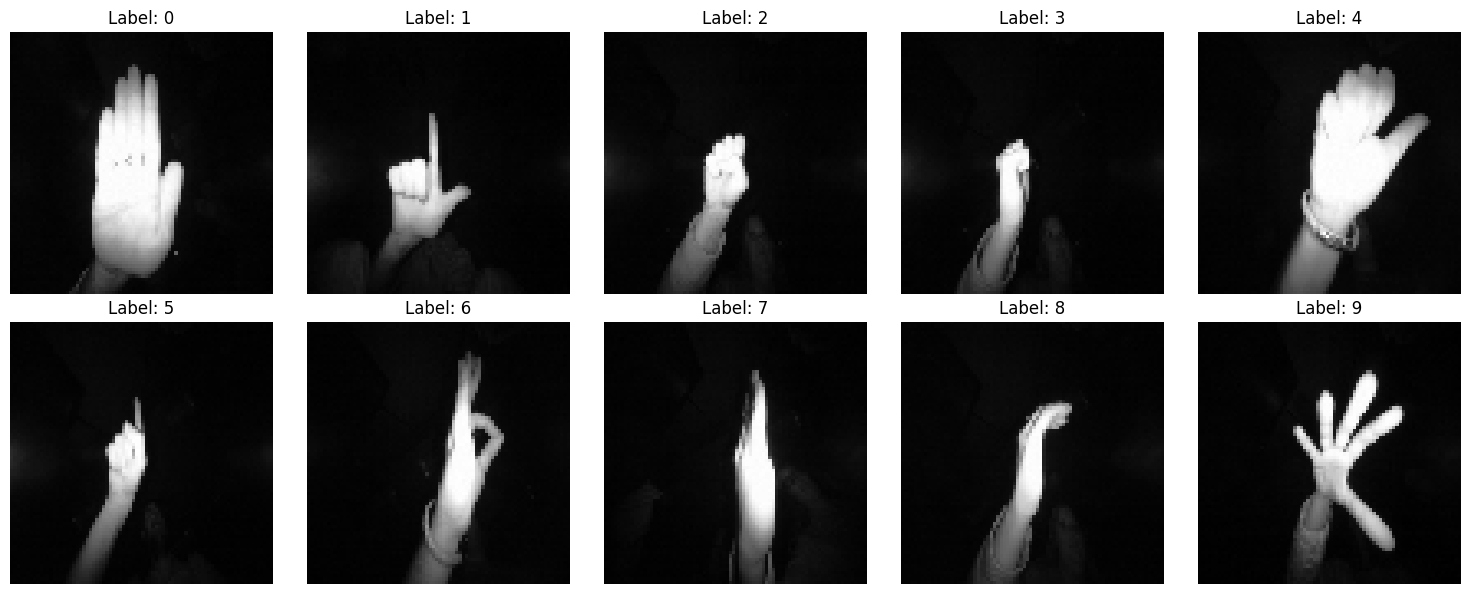

In [21]:
import random

def get_images_1_to_10(x_data, y_data):
    selected_images = []
    selected_labels = []

    for label in range(10):
        label_indices = [i for i, lbl in enumerate(y_data) if np.argmax(lbl) == label]
        
        selected_index = random.choice(label_indices)
        
        selected_images.append(x_data[selected_index])
        selected_labels.append(label)

    return np.array(selected_images), np.array(selected_labels)

selected_x, selected_y = get_images_1_to_10(x_train, y_train)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, label in zip(axes.ravel(), selected_x, selected_y):
    ax.imshow(img.reshape(image_shape[0], image_shape[1]), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

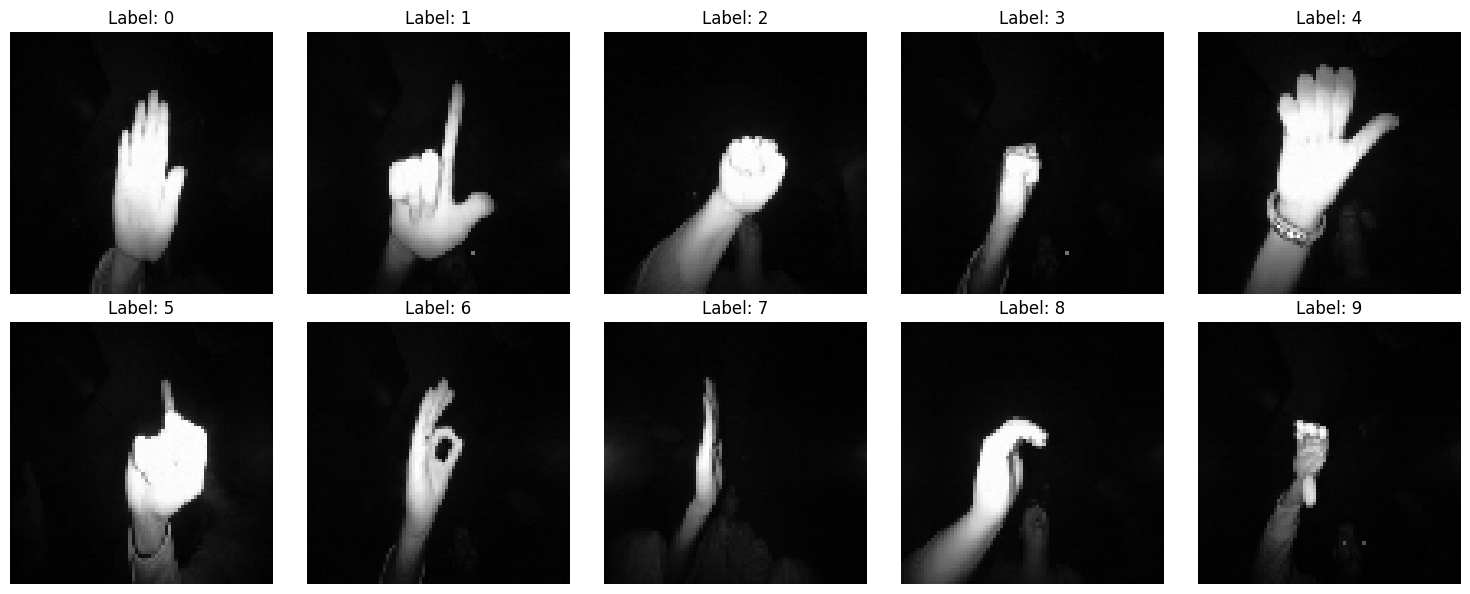

In [22]:
selected_x, selected_y = get_images_1_to_10(x_train, y_train)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, label in zip(axes.ravel(), selected_x, selected_y):
    ax.imshow(img.reshape(image_shape[0], image_shape[1]), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(lookup), activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.save('hand_gesture.h5')
#model.summary()                        #use to show summary

In [24]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=2
)

val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Epoch 1/5
250/250 - 26s - 105ms/step - accuracy: 0.8379 - loss: 0.4771 - val_accuracy: 0.9975 - val_loss: 0.0093
Epoch 2/5
250/250 - 25s - 101ms/step - accuracy: 0.9860 - loss: 0.0438 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 3/5
250/250 - 26s - 103ms/step - accuracy: 0.9925 - loss: 0.0249 - val_accuracy: 0.9995 - val_loss: 0.0016
Epoch 4/5
250/250 - 26s - 103ms/step - accuracy: 0.9929 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 2.8825e-04
Epoch 5/5
250/250 - 25s - 102ms/step - accuracy: 0.9959 - loss: 0.0129 - val_accuracy: 0.9998 - val_loss: 7.5025e-04
125/125 - 2s - 16ms/step - accuracy: 0.9998 - loss: 7.5025e-04
Validation Accuracy: 99.98%


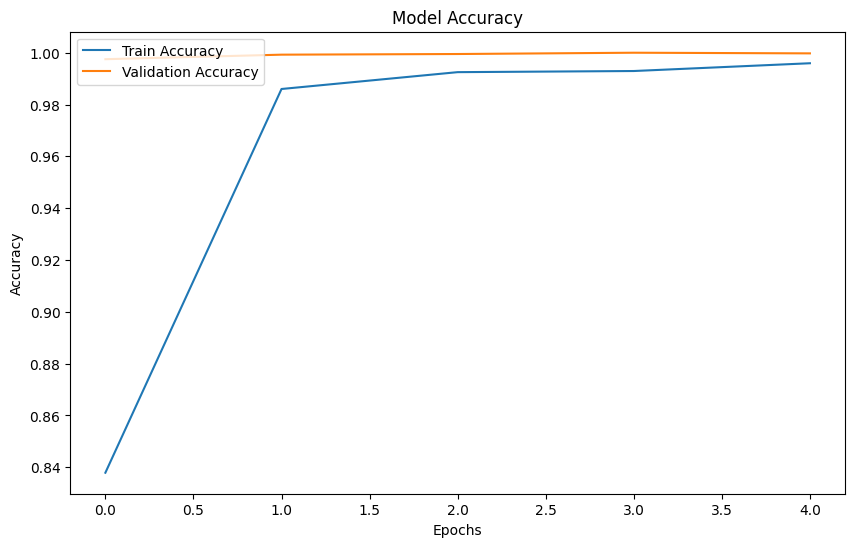

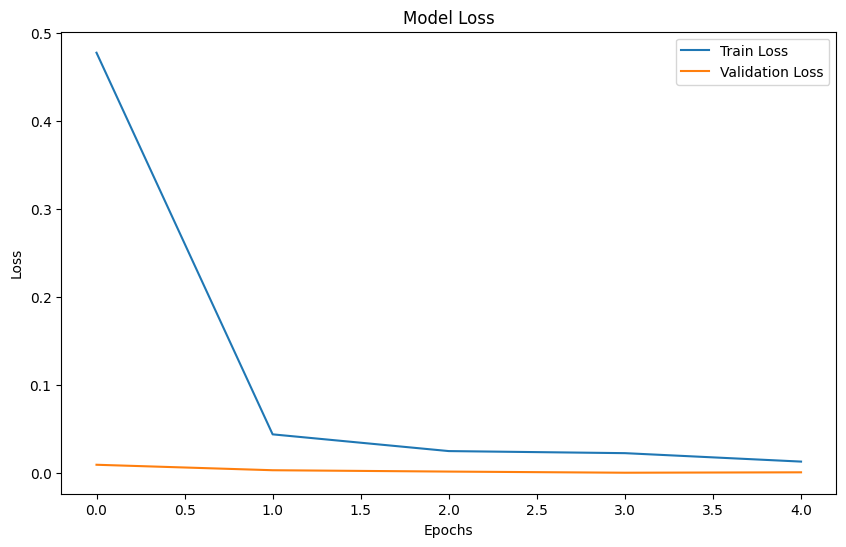

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


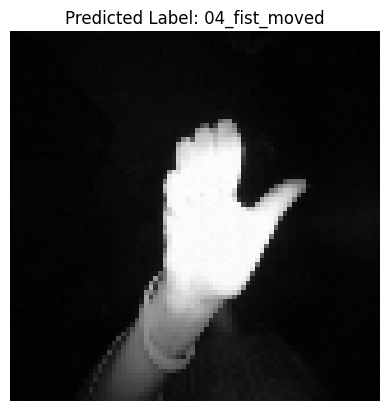

In [38]:
import random

random_idx = random.randint(0, len(x_val) - 1)
img = x_val[random_idx].reshape(1, IMG_SIZE, IMG_SIZE, 1)

prediction = model.predict(img)
predicted_class = np.argmax(prediction)
predicted_label = reverselookup[predicted_class]

plt.imshow(x_val[random_idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()